In [1]:
import numpy as np
from base import plotting
from base.classifiers import OnevsallContinuous
from base import img_tools
import base.classifiers.onevsall as oa
import glob
import pandas as pd
from base import tools
from scipy import stats
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pylab
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/datasets/abs_60topics_filt_jul.pkl")

In [3]:
clf = OnevsallContinuous.load('../results/classification/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_60/classifier.pkl')

In [4]:
SMA = [6, 3]
dACC = [9, 5, 1, 7]
mPFC = [2, 4, 8]

reg_num = SMA + dACC + mPFC
label_names = ['SMAc', 'SMAr',  'pSMAc','pSMAr', 'dACCc', 'dACCr', 'dmPFC' , 'rACC', 'vmPFC']

# reg_num = [1, 2, 3]
# label_names = ['Middle', 'Posterior', 'Anterior']

In [5]:
reg_pairs = zip(reg_num, label_names)

In [6]:
boot_n = 100

from multiprocessing import Pool
pool = Pool(processes=7)
import itertools
pool = itertools

pb = tools.ProgressBar(boot_n * len(clf.data), start=True)

def permutation_parallel(args):
    (X, y, cla, feat_names, region), i = args
    
    newY = np.random.permutation(y)
    cla_fits = cla.fit(X, newY)
    fit_w = np.log(cla_fits.theta_[1] / cla_fits.theta_[0])
    
    results = []
    for n, lo in enumerate(fit_w):
        results.append([region + 1, i, feat_names[n], lo])
        
    return results

In [7]:
overall_results = []
for reg, (X, y) in enumerate(clf.data):
    for result in pool.imap(permutation_parallel, itertools.izip(
            itertools.repeat((X, y, clf.classifier, clf.feature_names, reg)), range(boot_n))):
        for res in result:
            overall_results.append(res)
        pb.next()
        
overall_results = pd.DataFrame(overall_results, columns=['region', 'perm_n', 'topic_name', 'fi'])

[##########] 100%


In [8]:
overall_results

,region,perm_n,topic_name,fi
0,1,0,topic1,0.140555
1,1,0,topic10,0.085999
2,1,0,topic11,-0.012386
3,1,0,topic12,0.008627
4,1,0,topic15,-0.154574
5,1,0,topic19,-0.119213
6,1,0,topic2,-0.194054
7,1,0,topic20,-0.009568
8,1,0,topic23,0.066068
9,1,0,topic26,-0.027823


In [9]:
word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/topic_keys" + str(60) + "-july_cognitive.csv")
word_keys['top_2'] = word_keys.words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])
word_keys['top_3'] = word_keys.words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + ' ' + x.split(' ')[2])
word_keys['top_words'] = word_keys.words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + ' ' + x.split(' ')[2])
word_keys['topic_name'] = "topic" + word_keys['topic'].astype('str')
word_keys = pd.merge(pd.DataFrame(np.array([range(0, clf.feature_importances.shape[1]), clf.feature_names]).T, columns=['topic_order', 'topic_name']), word_keys)
word_keys.topic_order = word_keys.topic_order.astype('int')

In [10]:
labels = ['fear', 
 'reward',
 'gaze',
 'motor',
 'inhibition',
 'WM',
 'conflict',
 'switching',
'pain',
 'decision-making',
 'social',
 'episodic']

In [11]:
np.abs(overall_results.fi).mean()

0.10604736334796595

In [12]:
np.abs(overall_results.fi).mean()

0.10604736334796595

In [13]:
overall_results.fi.mean()

-0.005555688799664204

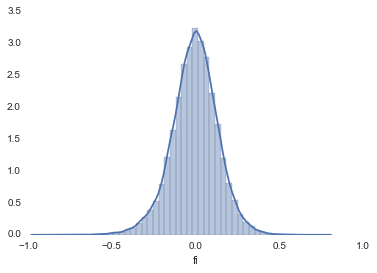

In [14]:
sns.distplot(overall_results.fi)

In [15]:
np.abs(clf.feature_importances).mean()

0.092353496064951357

In [16]:
np.abs(clf.odds_ratio).mean()

0.39840861993997406

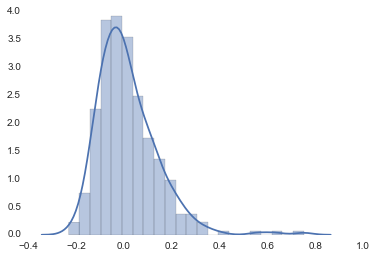

In [17]:
sns.distplot(clf.feature_importances.flatten())

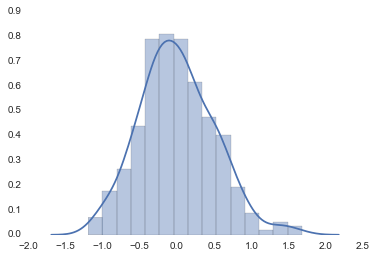

In [18]:
sns.distplot(clf.odds_ratio.flatten())

In [19]:
p_001 = pd.DataFrame(overall_results.groupby(['region', 'topic_name']).apply(lambda x: (3.090232 * x.fi.std()) + x.fi.mean())).reset_index()

In [20]:
p_001 = p_001.rename(columns={0:'threshold_001'})

In [21]:
p_001['region_names'] = p_001.region.map(dict(reg_pairs))

In [22]:
p_001 = pd.merge(p_001, word_keys)

In [23]:
p_01 = pd.DataFrame(overall_results.groupby(['region', 'topic_name']).apply(lambda x: (2.58 * x.fi.std()) + x.fi.mean())).reset_index()

In [24]:
p_05 = pd.DataFrame(overall_results.groupby(['region', 'topic_name']).apply(lambda x: (1.96 * x.fi.std()) + x.fi.mean())).reset_index()

In [25]:
p_001 = pd.merge(p_001, p_01.rename(columns={0:'threshold_01'}))
p_001 = pd.merge(p_001,  p_05.rename(columns={0:'threshold_05'}))

In [26]:
o_fi = pd.DataFrame(clf.odds_ratio)

# Melt feature importances, and add top_words for each feeature
o_fi['region'] = range(1, o_fi.shape[0] + 1)
o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

In [27]:
p_001 = pd.merge(p_001, o_fis_melt, on=['region', 'topic_order'], how='left')

In [28]:
p_001['sig_001'] = p_001.importance > p_001.threshold_001
p_001['sig_01'] = p_001.importance > p_001.threshold_01
p_001['sig_05'] = p_001.importance > p_001.threshold_05



In [29]:
p_001['z_imp'] = (p_001.importance - overall_results.fi.mean()) / overall_results.fi.std()

In [30]:
p_001[(p_001.region.isin(SMA) & p_001.nickname.isin(labels))][['region_names', 'nickname', 'sig_001', 'importance', 'z_imp', 'threshold_001']].pivot(columns='region_names', index='nickname')

sig_001        importance                z_imp             \
region_names       SMAc   SMAr       SMAc      SMAr       SMAc       SMAr   
nickname                                                                    
conflict          False  False  -0.206820  0.288133  -1.461691   2.132923   
decision-making   False  False  -0.072467 -0.282770  -0.485944  -2.013282   
fear              False  False   0.200851  0.154261   1.499040   1.160674   
gaze              False   True   0.379679  0.832921   2.797779   6.089466   
inhibition        False   True   0.231384  0.612942   1.720787   4.491863   
motor              True   True   1.678657  1.412210  12.231660  10.296574   
pain               True  False   0.860480  0.209034   6.289620   1.558468   
reward            False  False   0.015842 -0.163853   0.155404  -1.149637   
social            False  False  -0.303139 -0.258515  -2.161208  -1.837128   
switching          True   True   0.401215  0.569355   2.954188   4.175308   

                threshold_001            
region_names             SMAc      SMAr  
nickname                                 
conflict             0.449032  0.351880  
decision-making      0.465215  0.443797  
fear                 0.471547  0.498691  
gaze                 0.542664  0.500556  
inhibition           0.409787  0.405005  
motor                0.341253  0.279807  
pain                 0.549817  0.445145  
reward               0.487833  0.435417  
social               0.293953  0.295256  
switching            0.389612  0.320187

In [36]:
p_001[p_001.region_names == 'SMAr'].sort_values('z_imp')

,region,topic_name,threshold_001,region_names,topic_order,topic,cognitive,nickname,words,top_2,top_3,top_words,threshold_01,threshold_05,importance,sig_001,sig_01,sig_05,z_imp
236,3,topic53,0.628378,SMAr,26,53,T,gustation,food taste body weight eating women obese nerv...,food taste,food taste body,food taste body,0.526092,0.401801,-0.954319,False,False,False,-6.890432
254,3,topic58,0.366838,SMAr,28,58,T,motion,motion visual perception body human moving per...,motion visual,motion visual perception,motion visual perception,0.302662,0.224679,-0.432039,False,False,False,-3.097348
290,3,topic9,0.374251,SMAr,32,9,T,repetition priming,repetition priming hearing repeated suppressio...,repetition priming,repetition priming hearing,repetition priming hearing,0.309798,0.231479,-0.417212,False,False,False,-2.989672
137,3,topic35,0.229236,SMAr,15,35,T,emotion,emotional emotion negative neutral facial affe...,emotional emotion,emotional emotion negative,emotional emotion negative,0.190019,0.142365,-0.283421,False,False,False,-2.018010
173,3,topic4,0.443797,SMAr,19,4,T,decision-making,decision choice risk decisions choices uncerta...,decision choice,decision choice risk,decision choice risk,0.366970,0.273616,-0.282770,False,False,False,-2.013282
74,3,topic23,0.295256,SMAr,8,23,T,social,social empathy moral person judgments mentaliz...,social empathy,social empathy moral,social empathy moral,0.246282,0.186773,-0.258515,False,False,False,-1.837128
11,3,topic10,0.287906,SMAr,1,10,T,vision-shape,visual category adaptation color features disc...,visual category,visual category adaptation,visual category adaptation,0.238533,0.178537,-0.250047,False,False,False,-1.775626
29,3,topic12,0.318236,SMAr,3,12,T,object recognition,object objects visual recognition familiar unf...,object objects,object objects visual,object objects visual,0.261824,0.193275,-0.243958,False,False,False,-1.731406
101,3,topic29,0.435417,SMAr,11,29,T,reward,reward anticipation monetary responses rewards...,reward anticipation,reward anticipation monetary,reward anticipation monetary,0.360913,0.270381,-0.163853,False,False,False,-1.149637
200,3,topic48,0.308192,SMAr,22,48,T,LTM,memory encoding retrieval recognition episodic...,memory encoding,memory encoding retrieval,memory encoding retrieval,0.260248,0.201988,-0.140627,False,False,False,-0.980957


In [37]:
p_001[p_001.region_names == 'SMAc'].sort_values('z_imp')

,region,topic_name,threshold_001,region_names,topic_order,topic,cognitive,nickname,words,top_2,top_3,top_words,threshold_01,threshold_05,importance,sig_001,sig_01,sig_05,z_imp
95,6,topic27,0.483987,SMAc,10,27,T,language,sentences comprehension sentence language synt...,sentences comprehension,sentences comprehension sentence,sentences comprehension sentence,0.404986,0.308989,-1.058143,False,False,False,-7.644455
257,6,topic58,0.465174,SMAc,28,58,T,motion,motion visual perception body human moving per...,motion visual,motion visual perception,motion visual perception,0.385927,0.289631,-0.550099,False,False,False,-3.954767
293,6,topic9,0.470833,SMAc,32,9,T,repetition priming,repetition priming hearing repeated suppressio...,repetition priming,repetition priming hearing,repetition priming hearing,0.394492,0.301728,-0.533826,False,False,False,-3.836581
185,6,topic40,0.376827,SMAc,20,40,T,semantic,semantic words word lexical knowledge conceptu...,semantic words,semantic words word,semantic words word,0.315666,0.241347,-0.454236,False,False,False,-3.258554
14,6,topic10,0.379481,SMAc,1,10,T,vision-shape,visual category adaptation color features disc...,visual category,visual category adaptation,visual category adaptation,0.315086,0.236839,-0.447624,False,False,False,-3.210540
86,6,topic26,0.704836,SMAc,9,26,T,math,arithmetic numerical mental magnitude calculat...,arithmetic numerical,arithmetic numerical mental,arithmetic numerical mental,0.586068,0.441749,-0.375972,False,False,False,-2.690165
239,6,topic53,0.618203,SMAc,26,53,T,gustation,food taste body weight eating women obese nerv...,food taste,food taste body,food taste body,0.504502,0.366341,-0.363999,False,False,False,-2.603206
131,6,topic34,0.365738,SMAc,14,34,T,audition,auditory speech sounds music sound perception ...,auditory speech,auditory speech sounds,auditory speech sounds,0.308951,0.239948,-0.352114,False,False,False,-2.516895
77,6,topic23,0.293953,SMAc,8,23,T,social,social empathy moral person judgments mentaliz...,social empathy,social empathy moral,social empathy moral,0.243495,0.182181,-0.303139,False,False,False,-2.161208
32,6,topic12,0.387142,SMAc,3,12,T,object recognition,object objects visual recognition familiar unf...,object objects,object objects visual,object objects visual,0.324586,0.248571,-0.229198,False,False,False,-1.624213


In [31]:
p_001[(p_001.region.isin(dACC) & p_001.nickname.isin(labels))][['region_names', 'nickname', 'sig_001']].pivot(columns='region_names', index='nickname')

sig_001                     
region_names      dACCc  dACCr  pSMAc  pSMAr
nickname                                    
conflict           True   True   True   True
decision-making   False   True  False   True
fear               True   True  False  False
gaze              False  False  False  False
inhibition         True   True   True   True
motor             False  False   True  False
pain               True   True   True   True
reward             True   True  False  False
social            False  False  False  False
switching          True  False   True   True

In [32]:
p_001.pivot?

In [33]:
p_001[(p_001.region.isin(mPFC) & p_001.nickname.isin(labels))][['region_names', 'nickname', 'sig_001']].pivot(columns='region_names', index='nickname')

sig_001              
region_names      dmPFC   rACC  vmPFC
nickname                             
conflict          False  False  False
decision-making    True   True   True
fear              False  False   True
gaze              False  False  False
inhibition        False  False  False
motor             False  False  False
pain              False  False  False
reward            False   True   True
social             True   True   True
switching         False  False  False